In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr)
library(dplyr); library(tidyr)
library(ggplot2)
library(rwantshue)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [4]:
%%R
mdf = psmelt(physeq)

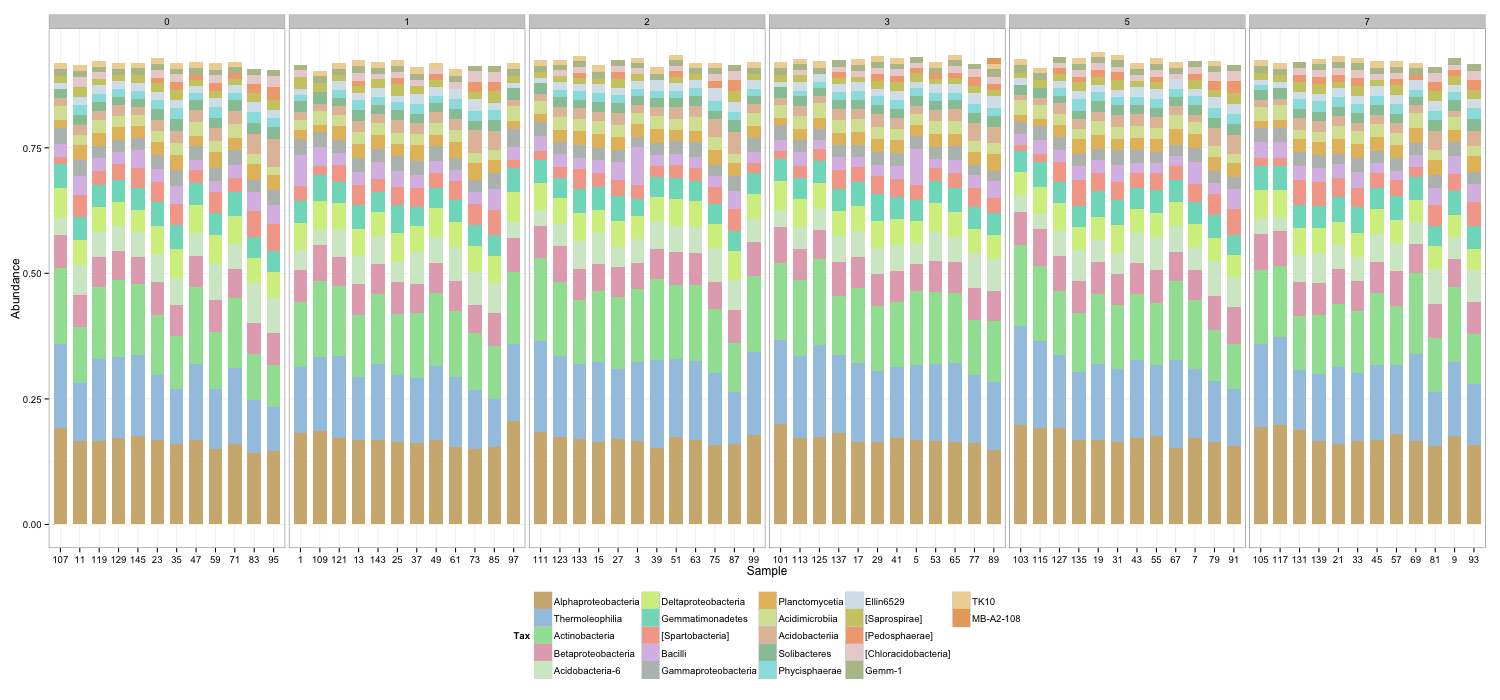

In [15]:
%%R -w 1500 -h 700

cutoff = 0.01
totabund = 00

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, Class, Trtmt, Day) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Day", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Day, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(~Day, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

#p = p + theme(axis.text.x=theme_text(angle=-90))

p = p + theme_bw()

p = p + theme(legend.position="bottom")

p

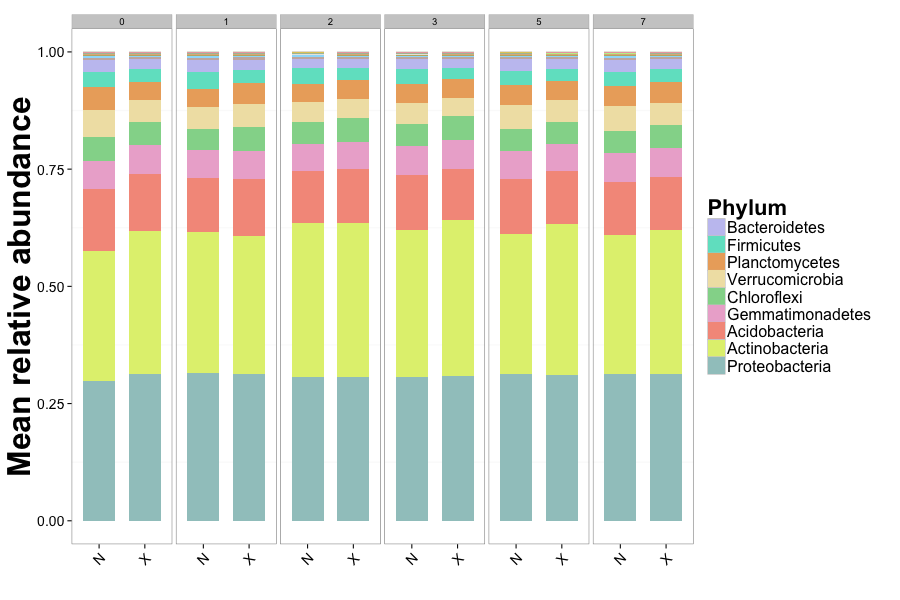

In [22]:
%%R -w 900 -h 600

cutoff = 0.00
totabund = 1500

d.plot = mdf %>%
    #filter(Month==2.5)%>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Phylum = ifelse(is.na(d.plot$Phylum)==TRUE, "Unidentified", paste(d.plot$Phylum))
d.plot$Phylum = ifelse(d.plot$Phylum=="unidentified", "Unidentified", paste(d.plot$Phylum))
d.plot = d.plot %>%
    mutate(Tax=Phylum)%>%
    group_by(Day, Trtmt, Tax, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Day, Trtmt, Tax) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Day, Trtmt) %>%
    group_by(Day, Trtmt,Tax)%>%
    summarize(Abundance = mean(Abundance))

colnames(d.plot) <- c("Day","Trtmt", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order( Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

p = p + facet_grid(~Day, scales = "free_x", space = "free")

N=50
Phyla=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]
p = p + scale_fill_manual(values = colors, breaks = Phyla)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 1, title = "Phylum", reverse="TRUE"))

#p = p + theme(axis.text.y=theme_text(angle=-90))

p = p + ylab("Mean relative abundance") + xlab("")

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(size = 14, angle = 45, hjust=1),
              axis.text.y = element_text(size = 14), 
              axis.title.x = element_text(size = 28),
              axis.title.y = element_text(size = 32,vjust=1,face='bold'),
              legend.title = element_text(size=22),
              legend.text = element_text(size = 16))

p = p + theme(legend.position="right", panel.grid.major= element_blank())

p

In [14]:
%%R
ggsave(filename="RelabundPhylum16S.Argonne.jpg", p, width=7, height=8.6)

In [26]:
%%R
levels(mdf$Kingdom)

[1] "Archaea"  "Bacteria"


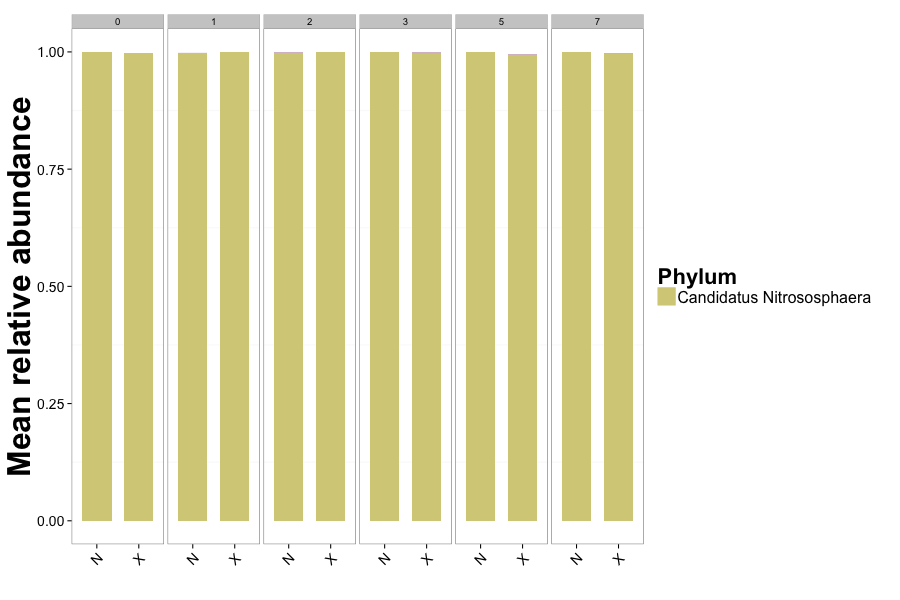

In [32]:
%%R -w 900 -h 600

cutoff = 0.00
totabund = 0

d.plot = mdf %>%
    filter(Kingdom=="Archaea")%>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Phylum = ifelse(is.na(d.plot$Phylum)==TRUE, "Unidentified", paste(d.plot$Phylum))
d.plot$Phylum = ifelse(d.plot$Phylum=="unidentified", "Unidentified", paste(d.plot$Phylum))
d.plot = d.plot %>%
    mutate(Tax=Genus)%>%
    group_by(Day, Trtmt, Tax, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Day, Trtmt, Tax) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Day, Trtmt) %>%
    group_by(Day, Trtmt,Tax)%>%
    summarize(Abundance = mean(Abundance))

colnames(d.plot) <- c("Day","Trtmt", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order( Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

p = p + facet_grid(~Day, scales = "free_x", space = "free")

N=0
Phyla=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]
p = p + scale_fill_manual(values = colors, breaks = Phyla)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 1, title = "Phylum", reverse="TRUE"))

#p = p + theme(axis.text.y=theme_text(angle=-90))

p = p + ylab("Mean relative abundance") + xlab("")

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(size = 14, angle = 45, hjust=1),
              axis.text.y = element_text(size = 14), 
              axis.title.x = element_text(size = 28),
              axis.title.y = element_text(size = 32,vjust=1,face='bold'),
              legend.title = element_text(size=22),
              legend.text = element_text(size = 16))

p = p + theme(legend.position="right", panel.grid.major= element_blank())

p